 # User Guide

## Import Statements

In [2]:
from herbie import Herbie, FastHerbie
import pandas as pd, numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import cartopy.crs as ccrs, cartopy.feature as cfeature
import metpy.calc as mpcalc
from metpy.units import units
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section
from copy import copy

## Formatting Data
Once you have the ECMWF data and the variable you want to analyze convert the data into a dataset. For this example we will use the ECMWF run intialized on 10-01-2024 at 00z analizing the 500 mb geopotential hieghts over the continental United States.

In [3]:
run = pd.Timestamp("2024-10-01", tz="utc").replace(tzinfo=None).floor('24h')
H = FastHerbie([run], model="ifs", product="oper", fxx=np.arange(0,246,6).tolist())
ss = r":gh:500"
ds = H.xarray(ss)
ds2 = ds.sel(latitude=slice(60,20), longitude=slice(-125,-65))
ds2

<xarray.Dataset> Size: 6MB
Dimensions:              (step: 41, latitude: 161, longitude: 241)
Coordinates:
    time                 datetime64[ns] 8B 2024-10-01
  * step                 (step) timedelta64[ns] 328B 0 days 00:00:00 ... 10 d...
    isobaricInhPa        float64 8B 500.0
  * latitude             (latitude) float64 1kB 60.0 59.75 59.5 ... 20.25 20.0
  * longitude            (longitude) float64 2kB -125.0 -124.8 ... -65.25 -65.0
    valid_time           (step) datetime64[ns] 328B 2024-10-01 ... 2024-10-11
    gribfile_projection  object 8B None
Data variables:
    gh                   (step, latitude, longitude) float32 6MB 5.501e+03 .....
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   ifs
    product:                 oper
    description:             ECMWF Open Data - Integrated Forecast System
    search:                  :gh:500

## Data Analysis
Now we can begin to test the accuracy of the ECMWF!
First, pick a forecast hour(s) to focus on and retrieve the data and time from that hour(s). For our example, we will use Hour 72.

In [5]:
def model_data(time_step):
    """ Pulls all the geopotential heights from a specfic hour """
    dss = ds2.isel(step=time_step)
    gh_val = dss['gh'].values
    return gh_val

ghh72 = model_data(12)

def model_time(time_step):
    """ Puts the time in a formatted string  """
    test_time = ds2['valid_time'].isel(step=time_step)
    test_time = test_time['valid_time'].values
    tt_str = test_time.astype(str)
    tt_str = tt_str[:-3]
    tt_object = datetime.strptime(tt_str, "%Y-%m-%dT%H:%M:%S.%f")
    formatted_tt = tt_object.strftime("%Hz %a %b %d %Y")
    return formatted_tt

ghh0_time = model_time(0)
ghh72_time = model_time(12)

**Finding Error**

Now we can find the error of the data by subtracting the actual values from the forecasted values. To do this we can download the real data from our selected fourecast hour. Our example can be seen below.

In [6]:
def varify_data(step_num):
    """ Downloads the varification data for any time """
    test_time = ds2['valid_time'].isel(step=step_num)
    test_time = test_time['valid_time'].values
    tt_str = test_time.astype(str)
    tt_str = tt_str[:-3]
    rt = pd.Timestamp(tt_str, tz="utc").replace(tzinfo=None)
    Hf = Herbie(rt, model="ifs", product="oper", fxx=0)
    dst = Hf.xarray(ss)
    dst = dst.sel(latitude=slice(60,20), longitude=slice(-125,-65))
    return dst

def varify_time(dsv):
    """ Puts the time in a formatted string  """
    test_time = dsv['valid_time']
    test_time = test_time['valid_time'].values
    tt_str = test_time.astype(str)
    tt_str = tt_str[:-3]
    tt_object = datetime.strptime(tt_str, "%Y-%m-%dT%H:%M:%S.%f")
    formatted_tt = tt_object.strftime("%Hz %a %b %d %Y")
    return formatted_tt 

dst72 = varify_data(12)
ghv72 = dst72['gh'].values 
ghv72_time = varify_time(dst72)
diff_72 = ghh72 - ghv72

✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


Now we can display our data by showing the what the model forecast, what actually occurred (varification), and the difference of the two.

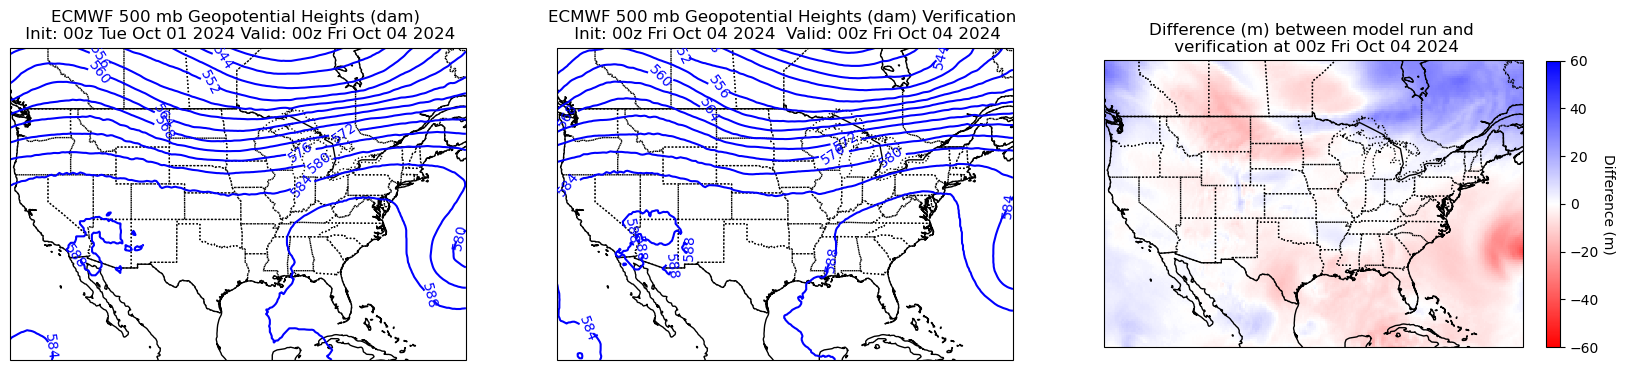

In [7]:
dataproj = ccrs.PlateCarree()
lat = ds2.latitude.values
lon = ds2.longitude.values

def create_map(title, subplot_pos):
    """ Creates a map for plotting """
    ax = fig.add_subplot(subplot_pos, projection=ccrs.Miller())
    ax.set_extent([-125,-65,20,55], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))
    ax.set_title(title)
    return ax

# Create an interval function to be used for each hour map
def generate_interval(start, end, interval):
  return list(range(start, end + 1, interval))

numbers = generate_interval(532, 600, 4) 

color_data = [
    [1.0, 0.0, 0.0], 
    [1.0, 1.0, 1.0],  
    [0.0, 0.0, 1.0]   
]

custom_cmap = LinearSegmentedColormap.from_list("custom_diverging", color_data)

fig = plt.figure(figsize=(20, 15))
ax1 = create_map(f'ECMWF 500 mb Geopotential Heights (dam) \n Init: {ghh0_time} Valid: {ghh72_time}', 131)
ax2 = create_map(f'ECMWF 500 mb Geopotential Heights (dam) Verification \n Init: {ghv72_time}  Valid: {ghv72_time}', 132)
ax3 = create_map(f'Difference (m) between model run and \n verification at {ghh72_time}', 133)

numbers = generate_interval(532, 600, 4) 

g_heights72 = ghh72 / 10
g_plt72 = ax1.contour(lon,lat, g_heights72, levels = numbers, colors = 'b', transform=dataproj)
plt.clabel(g_plt72)

geo_heights72 = ghv72 / 10
gh_plt72 = ax2.contour(lon,lat, geo_heights72, levels = numbers, colors = 'b', transform=dataproj)
plt.clabel(gh_plt72)

diff_plt72 = ax3.pcolormesh(lon ,lat, diff_72, vmin = -60, vmax = 60,cmap=custom_cmap, transform=dataproj)
im2_ratio = diff_72.shape[0]/diff_72.shape[1]
cbar_72 = plt.colorbar(diff_plt72, fraction=0.047*im2_ratio)
cbar_72.set_label('Difference (m)', rotation=270, labelpad=12)

**Finding Absolute Error**

We can use our model data to find the abosulte error across the run. To do this, subtract the varification data from the model data then take the absolute value of the answer. This data can be appened to the original dataset. You can also add forecast hour to the dataset, but this step is optional. 

In [8]:
def model_data(dsf, time_step):
    """ Pulls all the geopotential heights from a specfic hour """
    dss = dsf.isel(step=time_step)
    msl_val = dss['gh'].values
    return msl_val

def varify_data(dsf, step_num):
    """ Downloads the varification data for any time """
    test_time = dsf['valid_time'].isel(step=step_num)
    test_time = test_time['valid_time'].values
    tt_str = test_time.astype(str)
    tt_str = tt_str[:-3]
    rt = pd.Timestamp(tt_str, tz="utc").replace(tzinfo=None)
    Hf = Herbie(rt, model="ifs", product="oper", fxx=0, overwrite = True)
    dst = Hf.xarray(ss)
    return dst

abs_error_list= []
for i in range(0, len(ds['valid_time']), 2):
    vdata = varify_data(ds, i)
    mdata = model_data(ds, i)
    absolute_error = abs(mdata - vdata)
    abs_error_list.append(absolute_error)

fhr_list= []
for i in range(0, len(ds['valid_time']), 2):
    fhr = i * 6
    fhr_list.append(fhr)

dse = xr.concat(abs_error_list, dim='time')
dse.coords['fhr'] = ('time', fhr_list)
dse

✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-01 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-02 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-03 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-04 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-05 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=ifs ┊

<xarray.Dataset> Size: 87MB
Dimensions:              (time: 21, latitude: 721, longitude: 1440)
Coordinates:
  * time                 (time) datetime64[ns] 168B 2024-10-01 ... 2024-10-11
    step                 timedelta64[ns] 8B 00:00:00
    isobaricInhPa        float64 8B 500.0
  * latitude             (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude            (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    valid_time           (time) datetime64[ns] 168B 2024-10-01 ... 2024-10-11
    gribfile_projection  object 8B None
    fhr                  (time) int64 168B 0 12 24 36 48 ... 192 204 216 228 240
Data variables:
    gh                   (time, latitude, longitude) float32 87MB 0.0 ... 61.4
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   ifs
    product:                 oper
    description:             ECMWF Open Data - Integrated Forecast System
    remote_grib:             https://ecmwf-forecasts.s3.eu-central-1.amazonaw...
    local_grib:              /home/meteo/rfs5905/data/ifs/20241001/subset_cfe...
    search:                  :gh:500

In order to visualize our results we can plot the abosulte error at any location. In this example, the location is Fargo, North Dakota.

<Axes: title={'center': 'Absolute Difference at Latitude: 46.8 and Longitude: -96.7'}, xlabel='Forecast Hour', ylabel='Absolute Difference (m)'>

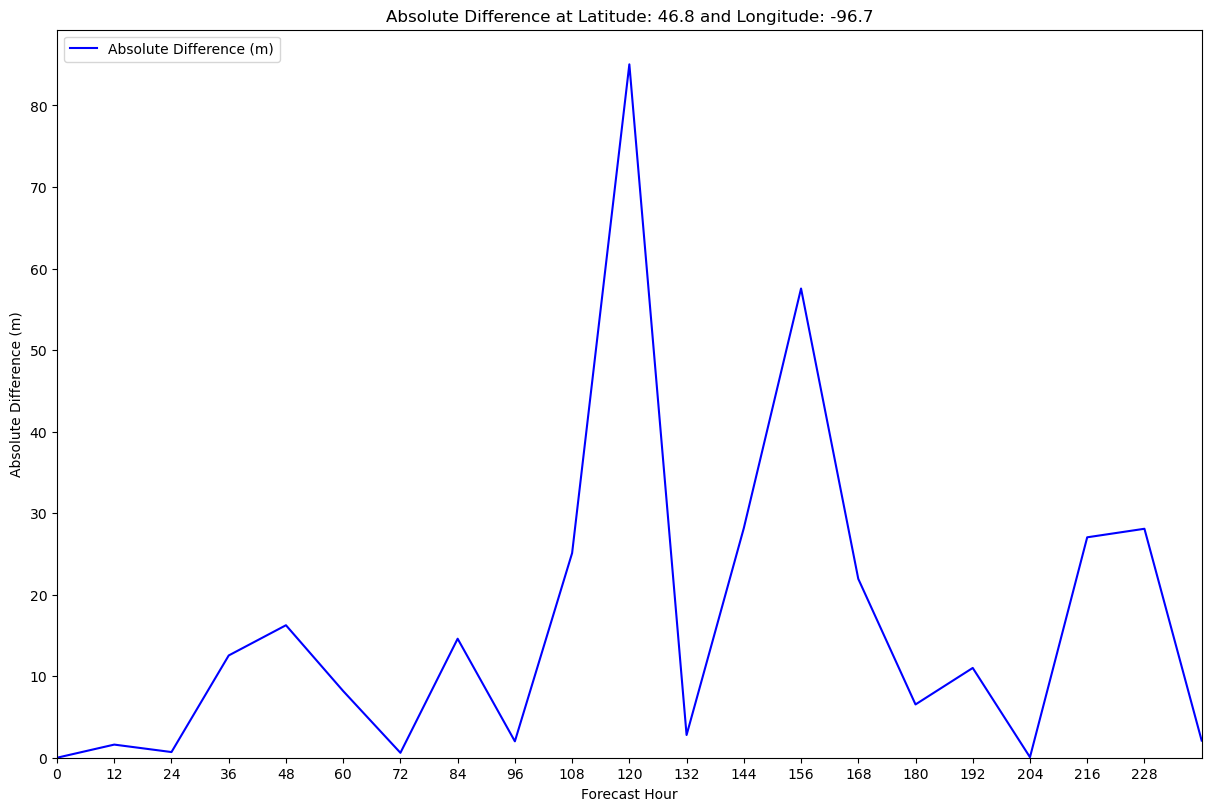

In [9]:
def forecast_abs_error(lat, lon, subplot_pos):
    """ Plots the absolute error of the data at any location """
    fig = plt.figure(figsize=(12, 8),  constrained_layout = True)
    ax = fig.add_subplot(subplot_pos)

    dsst = dse.sel(method = 'nearest', latitude = lat, longitude = lon)
    gh_error = dsst['gh'].values

    fhr_graph = dsst['fhr'].values

    plt.plot(fhr_graph, gh_error, color='b', label='Absolute Difference (m)')
    plt.title(f'Absolute Difference at Latitude: {lat} and Longitude: {lon}')
    plt.xlabel('Forecast Hour')
    plt.xlim(0, fhr_graph[-1])
    plt.xticks(np.arange(0, fhr_graph[-1], 12))
    plt.ylabel('Absolute Difference (m)')
    plt.ylim(bottom = 0)
    plt.legend(loc = 'upper left')
    return ax

forecast_abs_error(46.8, -96.7, 111)

**Root Mean Square Error**

Finally, we can find the root mean square error of the model data and plot it across the forecast hours in the model run. Our example can be found below.

<Axes: title={'center': 'Root Mean Square Error Across All Forecast Hours'}, xlabel='Forecast Hour', ylabel='Root Mean Square Error (m)'>

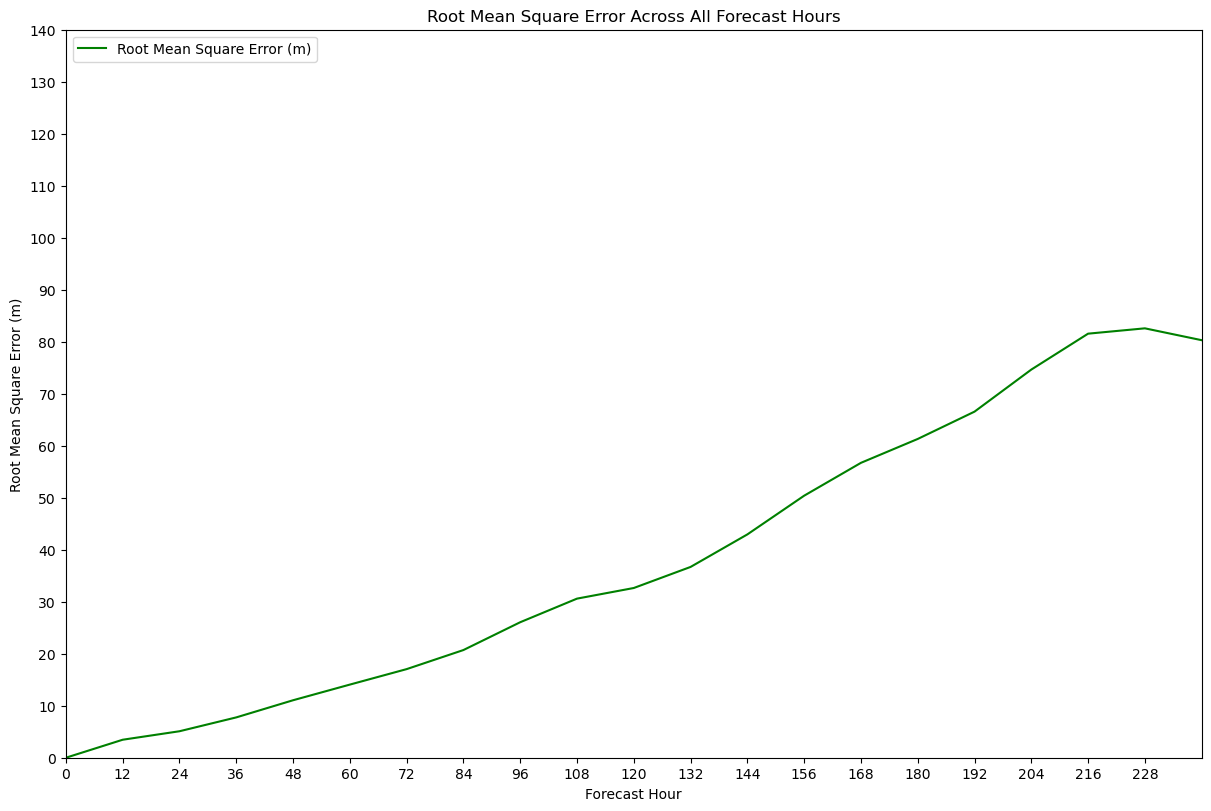

In [10]:
rmse_list= []
for i in range(0, len(dse['time']), 1):
    dss = dse.isel(time=i) 
    diff = dss['gh'].values
    mean_squared_error = ((diff)**2).mean()
    rmse = np.sqrt(mean_squared_error)
    rmse_list.append(rmse)

def rmse_plot(subplot_pos):
    """ Plots the RMSE of the data """
    fig = plt.figure(figsize=(12, 8),  constrained_layout = True)
    ax = fig.add_subplot(subplot_pos)

    fhr_graph = dse['fhr'].values
    
    plt.plot(fhr_graph, rmse_list, color='g', label='Root Mean Square Error (m)')
    plt.title(f'Root Mean Square Error Across All Forecast Hours')
    plt.xlabel('Forecast Hour')
    plt.xlim(0, fhr_graph[-1])
    plt.xticks(np.arange(0, fhr_graph[-1], 12))
    plt.ylabel('Root Mean Square Error (m)')
    plt.ylim(bottom = 0)
    plt.yticks(np.arange(0, 150, 10))
    plt.legend(loc = 'upper left')
    return ax

rmse_plot(111)